In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.express as px
import missingno
#from floweaver import *
import plotly as py
#from ipysankeywidget import SankeyWidget
import missingno
init_notebook_mode(connected=True)

master = pd.read_csv('../input/chinese-investments-geocoded/all_flow_classes.csv')
ms = master.copy() #working dataframe




In [2]:
print(ms.shape)

(6190, 78)


In [3]:
ms.rename(columns = {'recipient_condensed':'country'}, inplace = True) 
ms.rename(columns = {'transactions_start_year':'start_year'}, inplace = True) 
ms['flow_class'] = ms['flow_class'].replace({'ODA-like': 'Aid', 'OOF-like': 'Non-Aid', 'Vague (Official Finance)': 'Not Sure'})



In [4]:
ms  = ms.sort_values(by=['start_year'], ascending=True)

ms['Project'] = " "+ ms['project_title'] + " [" + ms['location_type_name']+ "]"
fig = px.scatter_geo(ms, 
                     lon = ms['longitude'],
                     lat = ms['latitude'],
                     text = ms['Project'],
                     opacity = 0.5,
                     color="flow_class", 
                     hover_name="place_name",
                     animation_frame="start_year",
                     projection="natural earth")

fig.update_layout(
    title = "Total Chinese Investment [2000 - 2014]",
    legend_title_text='Investment Category', 
    geo = dict(
        landcolor = "black",
        showcountries = True
    )
)
#fig.show()
iplot(fig)

In [5]:
values = ms['flow_class'].value_counts()
class_ = pd.unique(ms['flow_class'])

fig = px.pie(ms, values=values, labels=class_, names = class_)
fig.update_layout(
    
    title = "Total Chinese Investment [By Category]",
    legend_title_text='Investment Category',
    showlegend=True
    
)

fig.show()

In [6]:
values = ms['flow'].value_counts()
class_ = pd.unique(ms['flow'])

fig = px.pie(ms, values=values, labels=class_, names = class_, hole=.3)
fig.update_layout(
    
    title = "Total Chinese Investment [By Type]",
    legend_title_text='Type of Investment',
    showlegend=True
    
)

fig.show()

In [7]:
#Processing Data for TreeMap
ms_dp = ms.copy()
ms_dp.drop_duplicates(subset = 'project_id', inplace=True)

values_proj = ms_dp['country'].value_counts()
values_proj = values_proj.to_dict()

ms_dp['project_count'] = ms_dp['country'].map(values_proj)


ms1 = ms_dp.groupby(["country"]).sum()
values = ms1['usd_current']
values = values.to_dict()
ms_dp['amount_USD'] = ms_dp['country'].map(values)
#print(ms_dp[['country', 'project_count', 'amount_USD']])

ms1 = ms_dp.drop_duplicates(subset='country')

In [8]:
#Creating a TreeMap

fig = px.treemap(ms1, 
                  path = ['country', ], values = 'project_count',
                  color='amount_USD',
                  color_continuous_scale='Tropic',
                 color_continuous_midpoint=np.average(ms_dp['amount_USD']),
                  
                  
                )

fig.update_layout(
    title = "NO. OF PROJECTS BACKED BY CHINA [BY COUNTRY]",
    legend_title_text='Amount Invested', 
    
)

fig.show()

#fig.write_html('first_figure.html', auto_open=True)

In [9]:
ms_c = ms_dp.sort_values(by=['project_count'], ascending=False)
ms_c = ms_c.loc[ms_c['country'].isin(['Pakistan','Cambodia','Zimbabwe','Angola','Tanzania','Sri Lanka','Ghana','Kenya',
                                      'Liberia','Uganda','Sudan','Laos','Zambia','Nepal','Indonesia', 'Ethiopia', 'Myanmar','Cameroon'])]

ms_c
fig = px.histogram(ms_c, x = 'flow_class', title = 'NO. OF PROJECTS BY CATEGORY IN VARIOUS COUNTRIES', color ='flow_class', facet_col ='country',facet_col_wrap=6, log_y=True )
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.text = ''
        
for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.XAxis:
        fig.layout[axis].title.text = ''
        
fig.update_layout(
    # keep the original annotations and add a list of new annotations:
    annotations = list(fig.layout.annotations) + [
        dict(
            x=0.5,
            y=-0.15,
            font=dict(
                size=14
            ),
            showarrow=False,
            text="Flow_Class",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.05,
            y=0.5,
            font=dict(
                size=14
            ),
            showarrow=False,
            text="Count",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    ]
)

fig.show()

In [10]:
#Preprocessing for Bar Chart
values = ms_dp['ad_sector_names'].value_counts()
print(type(values))
values = values.to_dict()
ms_dp['values_sector'] = ms_dp['ad_sector_names'].map(values)
ms_dp  = ms_dp.sort_values(by=['values_sector'], ascending=False)

ms1 = ms.groupby(["ad_sector_names"]).sum()
values = ms1['usd_current']
values = values.to_dict()
ms_dp['amount_USD_sector'] = ms_dp['ad_sector_names'].map(values)


no_duplicates = ms_dp.drop_duplicates(['ad_sector_names']).sort_values('amount_USD_sector', ascending = False)

<class 'pandas.core.series.Series'>


In [11]:
#pd.set_option("display.precision", 3)
fig = px.bar(no_duplicates, y='amount_USD_sector', x='ad_sector_names', log_y = True )

fig.update_layout(
                 title="Chinese Investments By Sectors in USD [LOG]",
                 xaxis_title="Sectors",
                 yaxis_title="Amount Spent",
                 yaxis = dict(showexponent = 'all',exponentformat = 'e'))

fig.update_traces(
                  marker_line_color='blue',
                  marker_line_width=1.5,opacity=0.6,
                  marker_color='indianred')



fig.show()


In [12]:
ms.columns

Index(['project_id', 'project_location_id', 'precision_code', 'geoname_id',
       'place_name', 'latitude', 'longitude', 'location_type_code',
       'location_type_name', 'gazetteer_adm_code', 'gazetteer_adm_name',
       'location_class', 'geographic_exactness', 'project_title',
       'start_actual_isodate', 'end_actual_isodate', 'donors_iso3',
       'recipients', 'recipients_iso3', 'ad_sector_codes', 'ad_sector_names',
       'ad_purpose_codes', 'ad_purpose_names', 'status', 'start_year',
       'transactions_end_year', 'project_total_commitments',
       'total_disbursements', 'even_split_commitments',
       'even_split_disbursements', 'recommended_for_research', 'umbrella',
       'year', 'year_uncertain', 'crs_sector_code', 'crs_sector_name', 'flow',
       'all_recipients', 'country', 'sources_count', 'funding_agency',
       'cofinancing_agency', 'implementing_agency', 'recipient_agencies',
       'recipient_agencies_count', 'flow_class', 'intent', 'amount',
       'currenc

In [13]:
ms['amount'].value_counts().sum() - ms['amount'].isnull().sum()

1750

In [14]:
#edit - loan_type

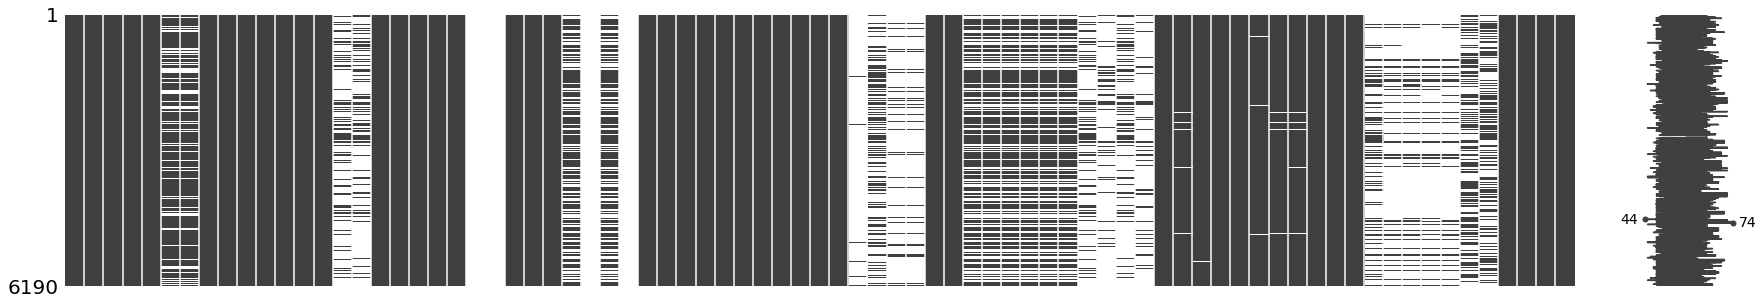

In [15]:
missingno.matrix(ms, figsize = (30,5))

In [16]:
to_drop = [
           "round_coded", 'contacts', 'location_details', 'grant_element', 'interest_rate', 'maturity', 'grace_period', 
           'line_of_credit','recipient_iso3','recipient_iso2','recipient_un_code','recipient_imf_code','recipient_oecd_code',
           'recipient_cow_code', 'start_actual','start_planned','end_actual','end_planned', 'amount','currency','deflators_used',
           'exchange_rates_used','usd_defl_2014', 'cofinancing_agency','implementing_agency','recipient_agencies','recipient_agencies_count',
           'sources_count','all_recipients', 'project_location_id','precision_code','place_name','longitude','latitude','location_type_code',
           'location_type_name','gazetteer_adm_code','gazetteer_adm_name','geographic_exactness','project_title','start_actual_isodate',
           'end_actual_isodate','donors_iso3','recipients','recipients_iso3','ad_sector_codes','ad_sector_names','ad_purpose_codes','ad_purpose_names',
           'transactions_end_year','project_total_commitments','total_disbursements','even_split_commitments','even_split_disbursements',
           'recommended_for_research','umbrella','year','crs_sector_code','all_recipients','sources_count','start_year', 'Project','recipient_oecd_name','source_triangulation','recipient_count'
            ,'field_completeness'
          ]

ms2 = ms.drop(to_drop, axis=1)

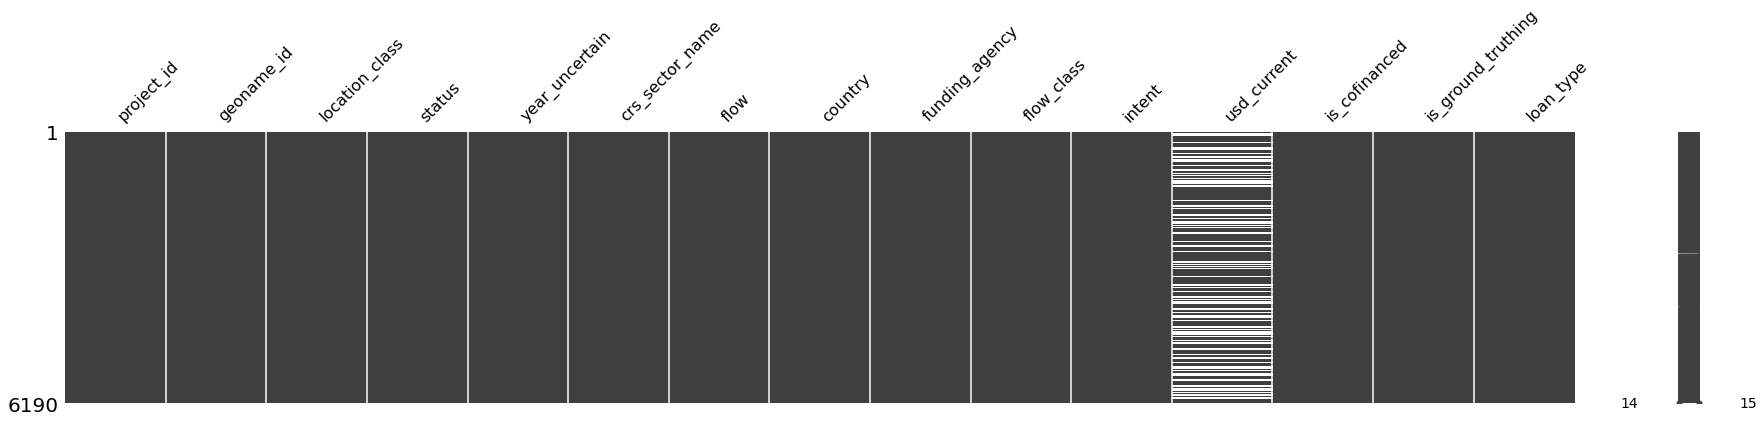

In [17]:
ms2['loan_type'].replace(np.nan, 'No Information', inplace=True)
missingno.matrix(ms2, figsize = (30,5))


In [18]:
#ms2.notnull().sum()
ms3 = ms2.copy()
#ms3['usd_current'].fillna(ms3['usd_current'].mean(), inplace=True)
ms3.dtypes

project_id              int64
geoname_id              int64
location_class          int64
status                 object
year_uncertain           bool
crs_sector_name        object
flow                   object
country                object
funding_agency         object
flow_class             object
intent                 object
usd_current           float64
is_cofinanced            bool
is_ground_truthing       bool
loan_type              object
dtype: object

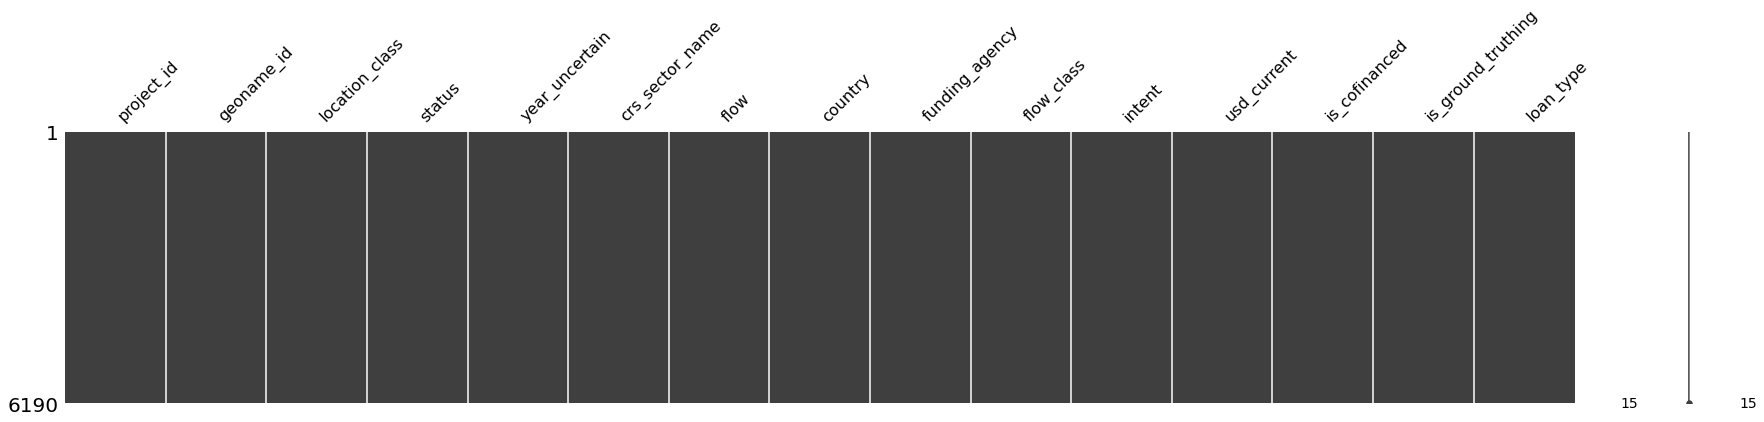

In [19]:
ms3['usd_current'] = ms3['usd_current'].fillna(ms3.groupby('country')['usd_current'].transform('mean'))
ms3['usd_current'].fillna(ms3['usd_current'].mean(), inplace=True)
missingno.matrix(ms3, figsize = (30,5))

In [20]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

'''ms3_df = ms3.select_dtypes(include=['object','bool']).astype('category')
ms3_df.dtypes'''

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

    
ms3_encoded = MultiColumnLabelEncoder(columns = ['status','year_uncertain','crs_sector_name','flow','country',
                                                 'funding_agency','flow_class','intent','is_cofinanced','is_ground_truthing',
                                                 'loan_type']).fit_transform(ms3)

In [21]:
y = ms3_encoded['flow_class']

X = ms3_encoded.drop('flow_class', axis = 1)


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix



steps = [ ('scaler',StandardScaler()),
         ('clf', KNeighborsClassifier())    
]

pipeline = Pipeline(steps)

param_grid = { 'clf__n_neighbors': [3,5,11,19] }

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

cv = GridSearchCV(pipeline, param_grid, cv = 5)

cv.fit(X_train, y_train)


y_pred = cv.predict(X_test)

print("Accuracy: {} \n".format(cv.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Tuned Model Parameters: {}".format(cv.best_params_))




Accuracy: 0.9380721593968767 

[[1253    7   26]
 [  34  294    8]
 [  36    4  195]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1286
           1       0.96      0.88      0.92       336
           2       0.85      0.83      0.84       235

    accuracy                           0.94      1857
   macro avg       0.92      0.89      0.91      1857
weighted avg       0.94      0.94      0.94      1857

Tuned Model Parameters: {'clf__n_neighbors': 3}
